In [2]:
import re
from enum import Enum
from typing import List, Tuple, Dict, Set, Optional, Union, Any, Callable
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
def replace_multiple_spaces_by_one(s):
    return re.sub(r" +", " ", s)

In [4]:
class Unit(Enum):
    ns = 1000000000
    us = 1000000
    ms = 1000
    s = 1

    def __str__(self):
        return self.name

def get_unit(s):
    unit = s.replace("/op", "")
    if unit == "ns":
        return Unit.ns
    elif unit == "us":
        return Unit.us
    elif unit == "ms":
        return Unit.ms
    elif unit == "s":
        return Unit.s
    else:
        raise Exception("Unknown unit")
    
def convert(n:float, current_unit:Unit, new_unit:Unit) -> float:
    return n * current_unit.value / new_unit.value

def verify_unit_or_convert(data: Tuple[Unit, List[Tuple[int, float, float]]], other_data: Tuple[Unit, List[Tuple[int, float, float]]] = ()) -> Tuple[Unit, List[Tuple[int, float, float]]]:
    unit = data[0] if other_data == () else other_data[0]
    u = data[0]
    res = [(x, convert(avg, u, unit), convert(err, u, unit)) for x, avg, err in data[1]]
    res.sort()
    return (unit, res)

In [5]:

def plot_data(data1: Tuple[Unit, List[Tuple[int, float, float]]], data1_name: str, data2: Tuple[Unit, List[Tuple[int, float, float]]], data2_name: str):
    unit1, dat1 = data1
    unit2, dat2 = data2
    assert unit1 == unit2
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot([x for x, _, _ in dat1], [y for _, y, _ in dat1], label=data1_name)
    ax.plot([x for x, _, _ in dat2], [y for _, y, _ in dat2], label=data2_name)
    ax.xlabel("Number of elements")
    ax.ylabel(f"Time ({unit1})")

    ax.legend()
    ax.show()

In [6]:
def plot_data_with_error(plot_name: str, data1: Tuple[Unit, List[Tuple[int, float, float]]], data1_name: str, data2: Tuple[Unit, List[Tuple[int, float, float]]], data2_name: str, data3_name: Optional[str], data3: Optional[Tuple[Unit, List[Tuple[int, float, float]]]] = None, x_line_at: int = 0, show_avg: bool = False):
    unit1, dat1 = data1
    unit2, dat2 = data2
    dat3 = None
    if data3 is not None:
        unit3, dat3 = data3
        assert unit1 == unit3
    assert unit1 == unit2


    # Choose colorblind-friendly colors
    color1 = 'tab:blue'  
    color2 = 'tab:orange'  
    color3 = 'tab:cyan'  

    # the error bar is shown in another colour, and it the 99% CI
    # The y axis always starts at 0
    plt.errorbar([x for x, _, _ in dat1], [y for _, y, _ in dat1], yerr=[y for _, _, y in dat1], label=data1_name, color=color1)
    plt.errorbar([x for x, _, _ in dat2], [y for _, y, _ in dat2], yerr=[y for _, _, y in dat2], label=data2_name, color=color2)
    if data3 is not None:
        assert dat3 is not None
        plt.errorbar([x for x, _, _ in dat3], [y for _, y, _ in dat3], yerr=[y for _, _, y in dat3], label=data3_name, color=color3)

    avg_1 = sum([y for _, y, _ in dat1]) / len(dat1)
    avg_2 = sum([y for _, y, _ in dat2]) / len(dat2)
    avg_3 = None

    max_y_value = max([y for _, y, _ in dat1] + [y for _, y, _ in dat2])
    if data3 is not None:
        assert dat3 is not None
        max_y_value = max(max_y_value, max([y for _, y, _ in dat3]))
        avg_3 = sum([y for _, y, _ in dat3]) / len(dat3)
    

    max_y_value = max_y_value + 0.15 * max_y_value
    plt.xlabel("Number of elements")
    plt.ylabel(f"Time ({unit1})")

    # Add a vertical line at x = x_line_at if not 0
    if x_line_at != 0:
        plt.axvline(x=x_line_at, color='black', linestyle='--')

    if show_avg:
        plt.axhline(y=avg_1, color=color1, linestyle='--')
        print(f"Average of {data1_name}: {avg_1}")
        plt.axhline(y=avg_2, color=color2, linestyle='--')
        print(f"Average of {data2_name}: {avg_2}")
        if data3 is not None:
            assert dat3 is not None
            assert avg_3 is not None
            plt.axhline(y=avg_3, color=color3, linestyle='--')
            print(f"Average of {data3_name}: {avg_3}")

    plt.legend()
    plt.title(plot_name)
    plt.show()
    
    


In [7]:
def extract_data(df: pd.DataFrame , benchmark_name: str, map_type_name: str, x_var_name: str) -> Tuple[Unit, List[Tuple[int, float, float]]]:
    benchmark_name = f"{benchmark_name}_{map_type_name}"
    data = df[df["Benchmark"].str.contains(benchmark_name)]
    unit = get_unit(df["Units"].to_list()[0])
    return (unit, [(int(param), float(avg), float(err)) for param, avg, err in data[[f"({x_var_name})", "Score", "Error"]].to_numpy()])

def extract_data_normalised_per_op(df: pd.DataFrame , benchmark_name: str, map_type_name: str, x_var_name: str) -> Tuple[Unit, List[Tuple[int, float, float]]]:
    benchmark_name = f"{benchmark_name}_{map_type_name}"
    data = df[df["Benchmark"].str.contains(benchmark_name)]
    unit = get_unit(df["Units"].to_list()[0])
    return (unit, [(int(param), float(avg)/float(param), float(err)/float(param) ) for param, avg, err in data[[f"({x_var_name})", "Score", "Error"]].to_numpy() if int(param) != 0] )


In [13]:
def create_plots(benchmark_classes: List[str], benchmark_names: Dict[str, List[str]], df: pd.DataFrame, variable_names: Dict[str, str] = {}, show_avg_for: str = "never"):
    for c in benchmark_classes:
        benchmark_func_names = benchmark_names[c]
        for n in benchmark_func_names:
            if variable_names != {}:
                variable_name = variable_names[c]
            else:
                # Only for legacy reasons
                variable_name = "n" if "LongListMapBenchmark" in c else "keysListName"
            map1_name = "ArrayFill"
            map2_name = "EfficientFill"
            map3_name = ""
            benchm_name = f"{c}.{n}"
            bench_name_pretty = f"{n}"
            map1_data = verify_unit_or_convert(extract_data(df, benchm_name, map1_name, variable_name))
            map2_data = verify_unit_or_convert(extract_data(df, benchm_name, map2_name, variable_name), map1_data)
            map3_data = None
            x_line_at = 0

            plot_data_with_error(bench_name_pretty, map1_data, map1_name, map2_data, map2_name, map3_name, map3_data, x_line_at, show_avg_for == "always")


# Array.fill Benchmark

In [14]:
data = """[info] Benchmark                                         (size)  Mode  Cnt       Score   Error  Units
[info] ArrayFillBenchmark.fillLong_ArrayFill                  2  avgt    2       0.010    ±0.0001      us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill                  8  avgt    2       0.012    ±0.0001      us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill                 32  avgt    2       0.023    ±0.0001      us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill                128  avgt    2       0.069    ±0.0001      us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill               1024  avgt    2       0.455    ±0.0001      us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill               2048  avgt    2       0.896    ±0.0001      us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill               8192  avgt    2       3.029    ±0.0001      us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill              32768  avgt    2      11.409    ±0.0001      us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill             131072  avgt    2      44.612    ±0.0001      us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill             524288  avgt    2     182.083    ±0.0001      us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill            2097152  avgt    2     751.102    ±0.0001      us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill           16777216  avgt    2    6873.623    ±0.0001      us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill           33554432  avgt    2   13750.296    ±0.0001      us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill              2  avgt    2       0.006    ±0.0001      us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill              8  avgt    2       0.009    ±0.0001      us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill             32  avgt    2       0.020    ±0.0001      us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill            128  avgt    2       0.067    ±0.0001      us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill           1024  avgt    2       0.456    ±0.0001      us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill           2048  avgt    2       0.900    ±0.0001      us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill           8192  avgt    2       3.144    ±0.0001      us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill          32768  avgt    2      11.461    ±0.0001      us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill         131072  avgt    2      45.093    ±0.0001      us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill         524288  avgt    2     180.894    ±0.0001      us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill        2097152  avgt    2     767.564    ±0.0001      us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill       16777216  avgt    2    6980.307    ±0.0001      us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill       33554432  avgt    2   13738.483    ±0.0001      us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill             2  avgt    2       0.013    ±0.0001      us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill             8  avgt    2       0.022    ±0.0001      us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill            32  avgt    2       0.077    ±0.0001      us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill           128  avgt    2       0.212    ±0.0001      us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill          1024  avgt    2       1.980    ±0.0001      us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill          2048  avgt    2       3.997    ±0.0001      us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill          8192  avgt    2      13.428    ±0.0001      us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill         32768  avgt    2      51.941    ±0.0001      us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill        131072  avgt    2     196.579    ±0.0001      us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill        524288  avgt    2   10300.052    ±0.0001      us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill       2097152  avgt    2   36467.565    ±0.0001      us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill      16777216  avgt    2  292491.294    ±0.0001      us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill      33554432  avgt    2  552940.697    ±0.0001      us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill         2  avgt    2       0.010    ±0.0001      us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill         8  avgt    2       0.014    ±0.0001      us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill        32  avgt    2       0.046    ±0.0001      us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill       128  avgt    2       0.119    ±0.0001      us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill      1024  avgt    2       0.837    ±0.0001      us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill      2048  avgt    2       1.660    ±0.0001      us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill      8192  avgt    2       6.859    ±0.0001      us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill     32768  avgt    2      42.102    ±0.0001      us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill    131072  avgt    2     152.626    ±0.0001      us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill    524288  avgt    2    4952.618    ±0.0001      us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill   2097152  avgt    2   17576.682    ±0.0001      us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill  16777216  avgt    2  171293.781    ±0.0001      us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill  33554432  avgt    2  346672.222    ±0.0001      us/op.""".strip().split("\n")


data = [replace_multiple_spaces_by_one(s.replace("[info]", "").replace("±", "")).replace(" ", ",") for s in data]
# create a panda dataframe from the data, using the first line as the column names
df = pd.DataFrame([s.split(",") for s in data[1:]], columns=data[0].split(","))
benchmark_classes = ["ArrayFillBenchmark"]

benchmark_names = {}
for n in benchmark_classes:
    benchmark_mutable_map_names = df["Benchmark"].unique().tolist()
    benchmark_mutable_map_names = [s.replace(f"{n}.", "") for s in benchmark_mutable_map_names if f"{n}." in s]
    benchmark_mutable_map_names = [s.replace("_ArrayFill", "").replace("_EfficientFill", "")for s in benchmark_mutable_map_names]
    # remove duplicates
    benchmark_mutable_map_names = list(set(benchmark_mutable_map_names))
    benchmark_names[n] = benchmark_mutable_map_names
benchmark_names

variable_names = {}
for n in benchmark_classes:
    variable_names[n] = "size"

variable_names

{'ArrayFillBenchmark': 'size'}

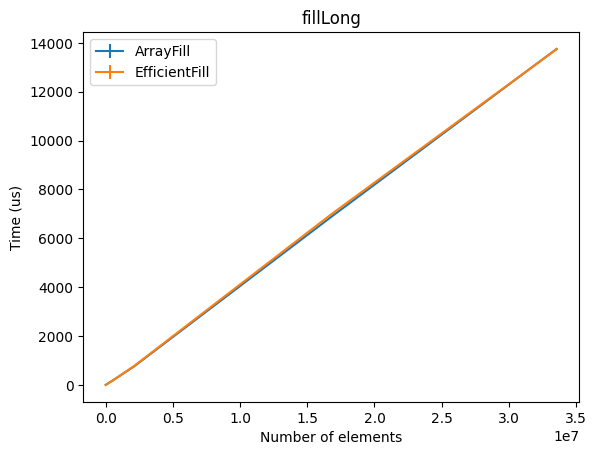

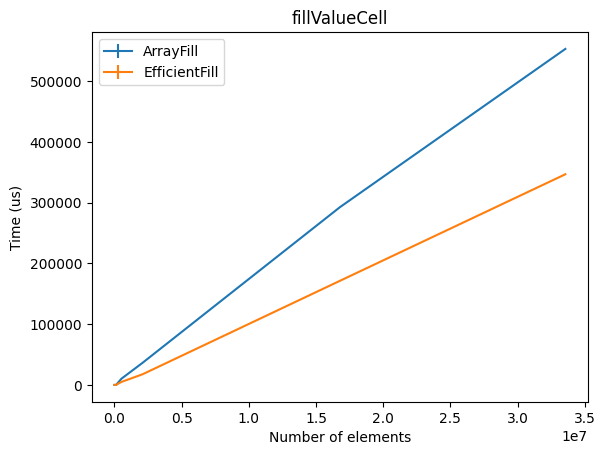

In [15]:
create_plots(benchmark_classes, benchmark_names, df, variable_names, show_avg_for="normalised")